# Map rotation

The surface of the star is based on an [HEALPix](https://HEALPix.jpl.nasa.gov/) map, that we need to rotate in order to simulate the star's rotation

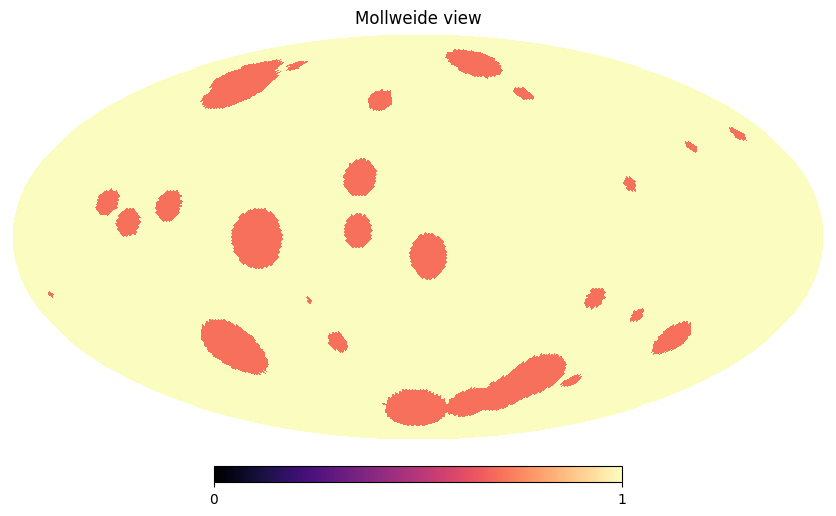

In [21]:
import jax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from spotter.core import spot
from spotter.distributions import uniform

N = 2**6
u = (0.5, 0.2)
np.random.seed(42)
radius = np.random.uniform(0.01, 0.2, size=30)
y = (
    1
    - (
        np.count_nonzero(
            jax.vmap(spot, in_axes=(None, 0, 0, 0))(N, *uniform(30), radius), 0
        )
        > 0
    )
    * 0.3
)

# limb darkening is only applied on disk so no point
# to show it here in this Mollewide projection
hp.mollview(y, cmap="magma", min=0, max=1)

And represented as a `Star`

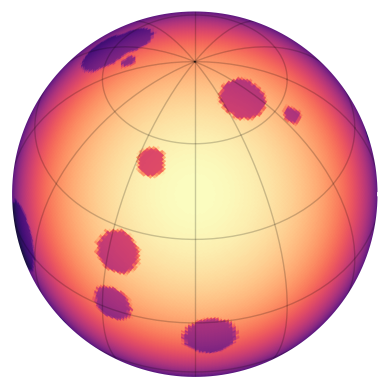

In [22]:
from spotter import Star, show

star = Star(y, u=u, period=2 * np.pi, inc=0.8)
show(star)

One way to perform the rotation is to use the `Rotation` object (and to project the result on a disk before multiplying it by the limb darkening law)

In [23]:
rotated_pixels = hp.Rotator(rot=np.pi / 4, deg=False).rotate_map_pixel(y)

But if we have to do that for say 1000 phases to compute the rotational light curve of the star (the disk-integrated flux) it can be very slow.

In [24]:
from time import time

phase = np.linspace(0, 2 * np.pi, 1000)

t0 = time()
for i in phase:
    rotated_pixels = hp.Rotator(rot=i, deg=False).rotate_map_pixel(y)
    flux = np.sum(rotated_pixels)
print(f"{time() - t0:.5f} s")

4.99250 s


So the idea is, instead of rotating the map, to rotate the point of view within the HEALPix sphere, compute a mask of the stellar disk being rotated, and compute the flux. This is illustrated below and implemented in the `Star` object.

In [25]:
from spotter.light_curves import design_matrix

few_phases = np.linspace(0, np.pi, 4)
X = design_matrix(star, few_phases)[:, 0, :]

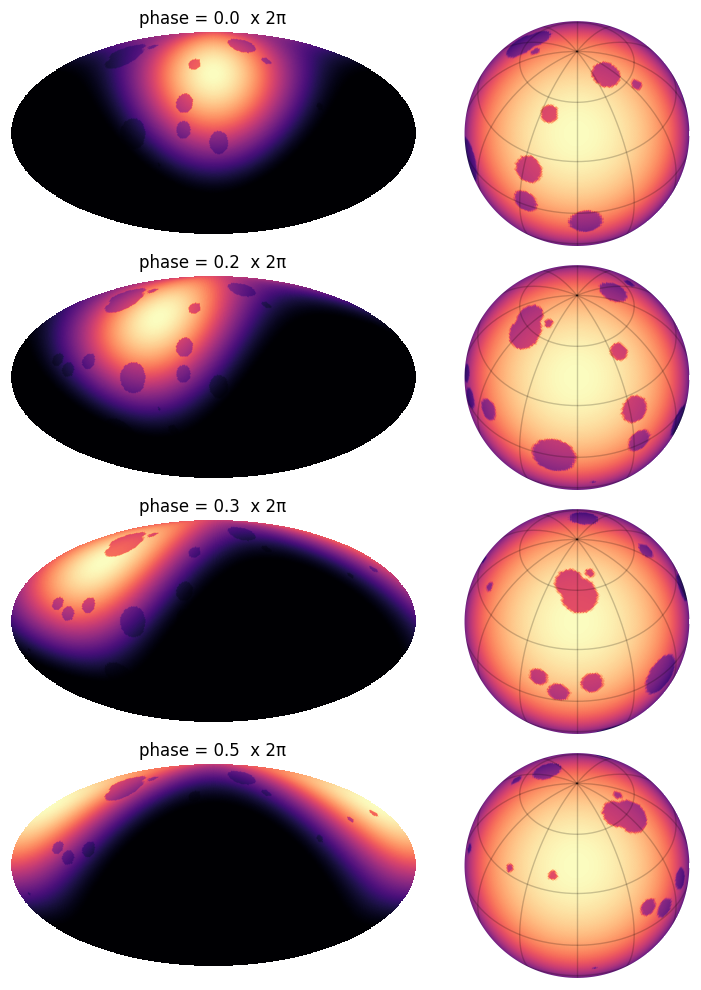

In [26]:
import jax

fig, axes = plt.subplots(4, 2, figsize=(8, 10))

for i, m in enumerate(X):
    ax = axes[i, 0]
    img = hp.mollview(m * star.y[0], return_projected_map=True)
    plt.close()
    ax.imshow(img, cmap="magma", origin="lower")
    ax.set_title(f"phase = {few_phases[i]/2/np.pi:.1f}  x 2π")
    ax.axis("off")

    ax = axes[i, 1]
    show(star, few_phases[i], ax=ax)

plt.tight_layout()

```{note}
The smooth edges around the spots of the projected disk (right plots) are due to interpolation when applying the healpy `Rotator` object. This is only present when the map is shown with `viz.show` as the `Rotator` object is not the way the flux is computed.
```

Let's make a small benchmark using the map above

In [27]:
from time import time
from spotter.light_curves import light_curve

# compilation
f = jax.jit(light_curve)
f(star, phase).block_until_ready()

t0 = time()
f(star, phase).block_until_ready()
print(f"{time() - t0:.5f} s")

0.13999 s


This is way faster than rotating the map with `healpy`.